# Download files

In [ ]:
! git clone https://github.com/byungjae89/SPADE-pytorch

fatal: destination path 'SPADE-pytorch' already exists and is not an empty directory.


# Install required libraries

In [ ]:
!pip install -r SPADE-pytorch/requirements.txt

In [ ]:
import numpy as np
import os
import csv
import time
import pickle

from tqdm.notebook import tqdm
from collections import OrderedDict
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2

Install custom libraries

In [ ]:
% cd "/content/SPADE-pytorch/src" 
import datasets.mvtec as mvtec

/content/SPADE-pytorch/src


# Code implementation

In [ ]:
def calc_dist_matrix(x, y):
    """Calculate Euclidean distance matrix with torch.tensor"""
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    dist_matrix = torch.sqrt(torch.pow(x - y, 2).sum(2))
    return dist_matrix


In [ ]:
def visualize_loc_result(test_imgs, gt_mask_list, score_map_list, threshold,
                         save_path, class_name, vis_num=5):

    for t_idx in range(vis_num):
        test_img = test_imgs[t_idx]
        test_img = denormalization(test_img)
        test_gt = gt_mask_list[t_idx].transpose(1, 2, 0).squeeze()
        test_pred = score_map_list[t_idx]
        test_pred[test_pred <= threshold] = 0
        test_pred[test_pred > threshold] = 1
        test_pred_img = test_img.copy()
        test_pred_img[test_pred == 0] = 0

        fig_img, ax_img = plt.subplots(1, 4, figsize=(12, 4))
        fig_img.subplots_adjust(left=0, right=1, bottom=0, top=1)

        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)

        ax_img[0].imshow(test_img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(test_gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax_img[2].imshow(test_pred, cmap='gray')
        ax_img[2].title.set_text('Predicted mask')
        ax_img[3].imshow(test_pred_img)
        ax_img[3].title.set_text('Predicted anomalous image')

        os.makedirs(os.path.join(save_path, 'images'), exist_ok=True)
        fig_img.savefig(os.path.join(save_path, 'images', '%s_%03d.png' % (class_name, t_idx)), dpi=100)
        fig_img.clf()
        plt.close(fig_img)


In [ ]:
def denormalization(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    return x

In [ ]:
class Spade(object):
  def __init__(self, modelType, device, save_path="./result"):
    self.device = device
    # load model
    self.model = modelType.to(self.device)
    self.model.eval()
    self.save_path = save_path
    
    os.makedirs(os.path.join(self.save_path, 'temp'), exist_ok=True)

  @torch.no_grad()
  #recupere les features du NN
  def forward(self, loader, is_train=True):
    outputs = []

    def hook(module, input, output):
        outputs.append(output)

    self.model.layer1[-1].register_forward_hook(hook)
    self.model.layer2[-1].register_forward_hook(hook)
    self.model.layer3[-1].register_forward_hook(hook)
    self.model.avgpool.register_forward_hook(hook)

    outputs_dict = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])

    phase = 'train' if is_train else 'test'
    for (x, y, mask) in tqdm(loader, f'| feature extraction | {phase} |'):
        # model prediction
        # This fills outputs automatically
        with torch.no_grad():
            # Comment fonctionne cette fonction ?
            pred = self.model(x.to(device))
        # get intermediate layer outputs
        for k, v in zip(outputs_dict.keys(), outputs):
            outputs_dict[k].append(v)
        # initialize hook outputs
        outputs = []
    for k, v in outputs_dict.items():
        outputs_dict[k] = torch.cat(v, 0)

    if is_train:
      self.train_outputs = outputs_dict
    else:
      return outputs_dict

  def ocsvm(self):
        # OCSVM à faire sur les features
        X_ocsvm = self.train_outputs['avgpool'].cpu()
        print('OCSVM')
        ocsvm_class = OneClassSVM(kernel='rbf').fit_predict(X_ocsvm.reshape((X_ocsvm.shape[0], -1)))
        result_mask = ocsvm_class > 0
        print(f'{np.sum(result_mask)} / {result_mask.size} valeurs normales')
        # Pour chaque feature matrix de train_outputs
        # On ne garde que les features des images "normales" selon l'OCSVM
        ocsvm_outputs_dict = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])
        for key in ocsvm_outputs_dict.keys():
          ocsvm_outputs_dict[key] = self.train_outputs[key][result_mask].to(self.device)
        self.train_outputs = ocsvm_outputs_dict


  def get_dist_matrix(self, test_outputs):
    return calc_dist_matrix(torch.flatten(test_outputs['avgpool'], 1),
                            torch.flatten(self.train_outputs['avgpool'], 1))

  def get_topk_values(self, dist_mat, top_k=5):
    values, _ = torch.topk(dist_mat, k=top_k, dim=1, largest=False)
    return values

  def get_topk_neighbours(self, dist_mat, top_k=5):
    _, neighbours = torch.topk(dist_mat, k=top_k, dim=1, largest=False)
    return neighbours

  def anomaly_detection(self, test_outputs, top_k=5):

    dist_matrix = calc_dist_matrix(torch.flatten(test_outputs['avgpool'], 1),
                                   torch.flatten(self.train_outputs['avgpool'], 1))

    # select K nearest neighbor and take average
    topk_values = self.get_topk_values(dist_matrix, top_k=top_k)
    scores = torch.mean(topk_values, 1).cpu().detach().numpy()

    return scores

  def anomaly_localization(self, test_outputs, neighbours):
    
    score_map_list = []
    for t_idx in tqdm(range(test_outputs['avgpool'].shape[0]), '| localization |'):
        score_maps = []
        for layer_name in ['layer1', 'layer2', 'layer3']:  # for each layer

            # construct a gallery of features at all pixel locations of the K nearest neighbors
            topk_feat_map = self.train_outputs[layer_name][neighbours[t_idx]]
            test_feat_map = test_outputs[layer_name][t_idx:t_idx + 1]
            feat_gallery = topk_feat_map.transpose(3, 1).flatten(0, 2).unsqueeze(-1).unsqueeze(-1)

            # calculate distance matrix
            dist_matrix_list = []
            for d_idx in range(feat_gallery.shape[0] // 100):
                dist_matrix = torch.pairwise_distance(feat_gallery[d_idx * 100:d_idx * 100 + 100], test_feat_map)
                dist_matrix_list.append(dist_matrix)
            dist_matrix = torch.cat(dist_matrix_list, 0)

            # k nearest features from the gallery (k=1)
            score_map = torch.min(dist_matrix, dim=0)[0]
            score_map = F.interpolate(score_map.unsqueeze(0).unsqueeze(0), size=224,
                                      mode='bilinear', align_corners=False)
            score_maps.append(score_map)

        # average distance between the features
        score_map = torch.mean(torch.cat(score_maps, 0), dim=0)

        # apply gaussian smoothing on the score map
        score_map = gaussian_filter(score_map.squeeze().cpu().detach().numpy(), sigma=4)
        score_map_list.append(score_map)

    return score_map_list


In [ ]:
def get_scores(classe, model, visualize=False, knn=5):
    my_spade = Spade(my_model, device)
    
    train_dataset = mvtec.MVTecDataset(class_name=class_name, is_train=True)
    train_dataloader = DataLoader(train_dataset, batch_size=32, pin_memory=True)
    test_dataset = mvtec.MVTecDataset(class_name=class_name, is_train=False)
    test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True)
    del train_dataset, test_dataset

    my_spade.forward(train_dataloader, is_train=True)
    #my_spade.ocsvm()
    my_class_test_outputs = (my_spade.forward(test_dataloader, is_train=False))
    
    gt_list = []
    gt_mask_list = []
    test_imgs = []

    # extract test set truth
    for (x, y, mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
        test_imgs.extend(x.cpu().detach().numpy())
        gt_list.extend(y.cpu().detach().numpy())
        gt_mask_list.extend(mask.cpu().detach().numpy())
    
    t0_det = time.time()
    scores = my_spade.anomaly_detection(my_class_test_outputs, top_k=knn)
    t1_det = time.time()
    time_det = t1_det-t0_det
    print(f'Detection Time {classe.upper()}: {time_det}')

    # calculate image-level ROC AUC score
    fpr, tpr, _ = roc_curve(gt_list, scores)
    roc_auc = roc_auc_score(gt_list, scores)

    #total_roc_auc.append(roc_auc)
    print('%s ROCAUC: %.3f' % (class_name, roc_auc))
    #fig_img_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, roc_auc))

    t0_loc = time.time()
    my_score_loc = my_spade.anomaly_localization(my_class_test_outputs,
                                                 my_spade.get_topk_neighbours(my_spade.get_dist_matrix(my_class_test_outputs), top_k=knn))
    t1_loc = time.time()
    time_loc = t1_loc-t0_loc
    print(f'Localization Time {classe.upper()}: {time_loc}')

    flatten_gt_mask_list = np.concatenate(gt_mask_list).ravel()
    flatten_score_map_list = np.concatenate(my_score_loc).ravel()

    # calculate per-pixel level ROCAUC
    fpr_pixel, tpr_pixel, _ = roc_curve(flatten_gt_mask_list, flatten_score_map_list)
    per_pixel_rocauc = roc_auc_score(flatten_gt_mask_list, flatten_score_map_list)
    print('%s pixel ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
    #fig_pixel_rocauc.plot(fpr_pixel, tpr_pixel, label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))

    if visualize:
      # get optimal threshold
      precision, recall, thresholds = precision_recall_curve(flatten_gt_mask_list, flatten_score_map_list)
      a = 2 * precision * recall
      b = precision + recall
      f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
      threshold = thresholds[np.argmax(f1)]

      # visualize localization result
      visualize_loc_result(test_imgs, gt_mask_list, my_score_loc, threshold, my_spade.save_path, class_name, vis_num=5)

    return fpr, tpr, roc_auc, fpr_pixel, tpr_pixel, per_pixel_rocauc

7


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "



Detection Time BOTTLE: 0.0035314559936523438
bottle ROCAUC: 0.969



Localization Time BOTTLE: 147.8220729827881
bottle pixel ROCAUC: 0.973


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "



Detection Time CAPSULE: 0.003968715667724609
capsule ROCAUC: 0.874



Localization Time CAPSULE: 235.07486128807068
capsule pixel ROCAUC: 0.985


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "



Detection Time CARPET: 0.005184650421142578
carpet ROCAUC: 0.927



Localization Time CARPET: 208.38254737854004
carpet pixel ROCAUC: 0.990


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "



Detection Time LEATHER: 0.004193782806396484
leather ROCAUC: 0.949



Localization Time LEATHER: 220.82921838760376
leather pixel ROCAUC: 0.993
Average ROCAUC: 0.930
Average pixel ROCAUC: 0.985


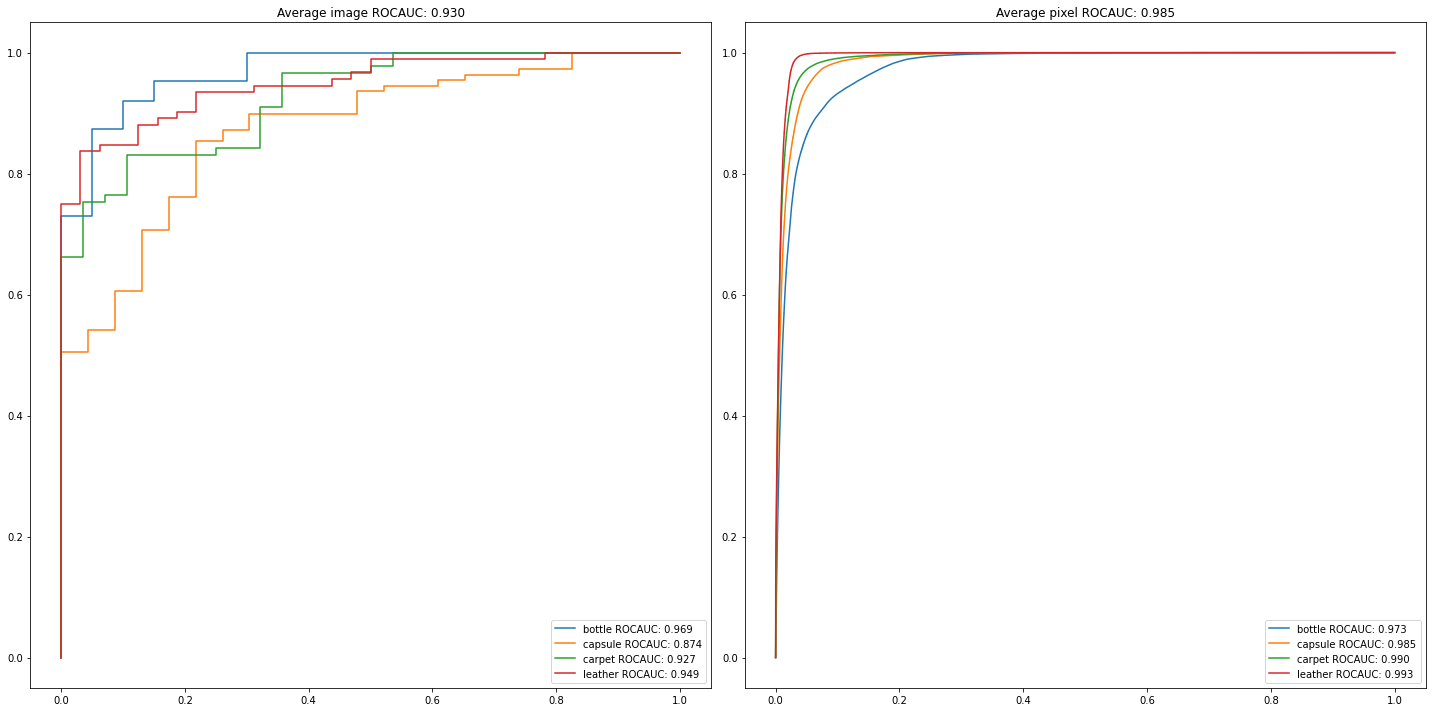

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
my_model = wide_resnet50_2(pretrained=True, progress=True)

result_folder = './my_results'
os.makedirs(result_folder, exist_ok=True)

for k in range(7,13,5):
  image_path = os.path.join(result_folder, f'roc_curve_k_{k}.png')
  if os.path.isfile(image_path):
    print(k)
    continue

  fig, ax = plt.subplots(1, 2, figsize=(20, 10))
  fig_img_rocauc = ax[0]
  fig_pixel_rocauc = ax[1]

  total_roc_auc = []
  total_pixel_roc_auc = []

  for class_name in mvtec.CLASS_NAMES[:]:
      if class_name not in ['bottle', 'capsule', 'carpet', 'leather']:
        #print(class_name)
        continue

      class_folder = ''.join([result_folder, '/', class_name])
      
      if os.path.isdir(class_folder) and False:
        print(f'{class_name} déjà calculé')
        continue
      else:
        fpr_image, tpr_image, roc_auc, fpr_pixel, tpr_pixel, per_pixel_rocauc = get_scores(class_name, my_model, visualize=False, knn=k)

        os.makedirs(class_folder, exist_ok=True)

        np.savetxt(f'{class_folder}/{class_name}_k_{k}_fpr_image.npy', fpr_image)
        np.savetxt(f'{class_folder}/{class_name}_k_{k}_tpr_image.npy', tpr_image)
        np.savetxt(f'{class_folder}/{class_name}_k_{k}_fpr_pixel.npy', fpr_pixel)
        np.savetxt(f'{class_folder}/{class_name}_k_{k}_tpr_pixel.npy', tpr_pixel)

        with open(f"{result_folder}/roc_auc.csv", "a") as fp:
            wr = csv.writer(fp, dialect='excel')
            wr.writerow([class_name, k, roc_auc, per_pixel_rocauc])
        
        total_roc_auc.append(roc_auc)
        total_pixel_roc_auc.append(per_pixel_rocauc)

        fig_img_rocauc.plot(fpr_image, tpr_image, label='%s ROCAUC: %.3f' % (class_name, roc_auc))
        fig_pixel_rocauc.plot(fpr_pixel, tpr_pixel, label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
        torch.cuda.empty_cache()

  print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
  fig_img_rocauc.title.set_text('Average image ROCAUC: %.3f' % np.mean(total_roc_auc))
  fig_img_rocauc.legend(loc="lower right")

  print('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
  fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
  fig_pixel_rocauc.legend(loc="lower right")

  fig.tight_layout()
  fig.savefig(image_path, dpi=100)